In [ ]:
pip install mesa

In [80]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import seaborn as sns 
from scipy.stats import stats, normaltest
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [81]:
# Patch class representing a patch of flowers
class Patch(Agent):
    def __init__(self, unique_id, model, nectar_amount, size):
        super().__init__(unique_id, model)
        self.nectar_amount = nectar_amount
        self.initial_nectar_amount = nectar_amount
        self.size = size
        self.visits = 0
        self.profitability = 1.0

    
    def update_profitability(self):
        self.profitability = (self.nectar_amount / self.initial_nectar_amount) * (0.999 ** self.visits)
        self.visits += 1

In [91]:
# Bee class representing a bee with different roles
class Bee(Agent):
    def __init__(self, unique_id, model, speed, role="novice"):
        super().__init__(unique_id, model)
        self.speed = speed
        self.has_food = False 
        self.role = role
        self.patch = None
        self.nectar_collected = 0
        self.waggle_time = 0
        self.communicated = False
        self.novice_target_distance = None 
        self.target_pos = None
        self.failed_trips = np.random.randint(1, 6) if role == "recruit" else 0
        self.failed_trip_distance = None
        self.recruit_state = "outbound"
        self.released = False

    def step(self):
        if self.role == "novice":
            self.novice_behavior()
        elif self.role == "scout":
            self.scout_behavior()
        elif self.role == "recruit":
            self.recruit_behavior()
        elif self.role == "employed":
            self.employed_behavior()

    def novice_behavior(self):
        if not self.released:
            return
        if self.communicated:
            if sum(1 for agent in self.model.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.model.hive_pos) > 20:
                self.role = "recruit"
                self.target_pos = self.patch.pos if self.patch else None
        else:
            if self.novice_target_distance is None:
                self.novice_target_distance = self.model.distance + np.random.randint(1, 6)
            self.travel_straight_line_as_novice()
            self.find_patch()

    def recruit_behavior(self):
        if self.recruit_state == "outbound":
            self.perform_outbound_behavior()
        elif self.recruit_state == "returning":
            self.perform_returning_behavior()
        elif self.recruit_state == "heading_to_patch":
            self.travel_straight_line_as_recruit()

    def scout_behavior(self):
        self.leave_hive()
        if not self.released:
            return
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos:
                self.model.total_nectar_collected += self.nectar_collected
                self.nectar_collected = 0
                self.has_food = False
                self.perform_waggle()
                self.role = "employed"
        else:
            if self.novice_target_distance is None:
                self.novice_target_distance = self.model.distance + np.random.randint(1, 6)
            self.travel_straight_line_as_novice()
            self.find_patch()
            if self.patch and self.pos == self.patch.pos:
                self.collect_nectar()


    def employed_behavior(self):
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos:
                self.model.total_nectar_collected += self.nectar_collected
                self.nectar_collected = 0
                self.has_food = False
                self.perform_waggle()
        
        else:
            if self.patch and not self.has_food:
                if self.patch.profitability < 0.1 and np.random.random() < 0.5:
                    self.patch = None 
                    self.role = "novice"
                else:
                    self.move_straight_line(self.patch.pos)
                    if self.pos == self.patch.pos:
                        self.collect_nectar()

    def perform_waggle(self):
        if self.model.use_waggle_dance and self.patch:
            profitability_multiplier = self.patch.profitability * 2
            self.waggle_time = int(np.linalg.norm(np.array(self.patch.pos) - np.array(self.model.hive_pos)) * 1000 / self.speed)
            novices_in_hive = [agent for agent in self.model.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.model.hive_pos]
            base_recruitment = np.random.randint(1, 6)
            num_to_communicate = min(len(novices_in_hive), int(base_recruitment * profitability_multiplier))
            for agent in np.random.choice(novices_in_hive, num_to_communicate, replace=False):
                agent.role = "recruit"
                agent.patch = self.patch
                agent.communicated = True
                agent.target_pos = self.target_pos

    def perform_outbound_behavior(self):
        if self.failed_trip_distance is None:
            self.failed_trip_distance = self.model.distance + np.random.randint(1, 6)
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.failed_trip_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.failed_trip_distance * np.sin(angle))
            )

        # Check if the recruit encounters a patch cell
        for agent in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                self.patch = agent.parent_patch
                self.collect_nectar()
                self.role = "employed"
                self.failed_trips = 0  # Stop the failed trips
                return

        self.travel_straight_line_as_recruit()

    def perform_returning_behavior(self):
        self.return_to_hive()
        if self.pos == self.model.hive_pos:
            self.returning_to_hive = False
            self.failed_trips -= 1
            self.failed_trip_distance = None
            self.target_pos = None
            if self.failed_trips > 0:
                self.recruit_state = "outbound"
            else:
                if np.random.random() > 0.4:
                    self.recruit_state = "heading_to_patch"
                    if self.patch: 
                        self.target_pos = self.patch.pos
                else:
                    self.role = "novice"


    def travel_straight_line_as_recruit(self):
        if self.target_pos is None:
            return
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            if self.recruit_state == "outbound":
                self.recruit_state = "returning"
            elif self.recruit_state == "heading_to_patch":
                for agent in self.model.grid.get_cell_list_contents([self.target_pos]):
                    if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                        self.patch = agent.parent_patch
                        self.collect_nectar()
                        self.role = "employed"
                        break

    def move_straight_line(self, target):
        if target:
            direction = np.arctan2(target[1] - self.pos[1], target[0] - self.pos[0])
            new_position = (
                int(round(self.pos[0] + self.speed * np.cos(direction))),
                int(round(self.pos[1] + self.speed * np.sin(direction)))
            )
            if 0 <= new_position[0] < self.model.grid.width and 0 <= new_position[1] < self.model.grid.height:
                self.model.grid.move_agent(self, new_position)

    def random_move(self):
        angle = np.deg2rad(self.random.choice(range(0, 360, 5)))
        target = (self.pos[0] + self.speed * np.cos(angle), self.pos[1] + self.speed * np.sin(angle))
        target = (int(round(target[0])), int(round(target[1])))
        if 0 <= target[0] < self.model.grid.width and 0 <= target[1] < self.model.grid.height:
            self.model.grid.move_agent(self, target)

    def return_to_hive(self):
        self.move_straight_line(self.model.hive_pos)

    def travel_straight_line_as_novice(self):
        if self.target_pos is None:
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.novice_target_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.novice_target_distance * np.sin(angle))
            )
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            self.return_to_hive()
            self.novice_target_distance = None
            self.target_pos = None

    def find_patch(self):
        for agent in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                self.patch = agent.parent_patch
                self.target_pos = agent.pos
                self.role = "employed"
                break

    def collect_nectar(self):
        nectar_amount = np.random.randint(15, 41)
        if self.patch:
            self.nectar_collected = min(self.patch.nectar_amount, nectar_amount) - 1
            self.patch.nectar_amount -= self.nectar_collected + 1
            self.has_food = True

            if self.patch.nectar_amount <= 0:
                self.patch.nectar_amount = 0
                self.role = "novice"
                self.patch = None

    def leave_hive(self):
        if self.patch:
            self.move_straight_line(self.patch.pos)
        elif self.role == "scout":
            self.released = True  # Ensure scouts are released immediately


In [92]:
# HoneybeeModel class
class HoneybeeModel(Model):
    def __init__(self, num_agents, width, height, distance, patch_size, use_waggle_dance, speed):
        super().__init__()
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.hive_pos = (width // 2, height // 2)
        self.distance = distance
        self.patch_size = patch_size
        self.use_waggle_dance = use_waggle_dance
        self.speed = speed
        self.total_nectar_collected = 0
        self.step_count = 0

        # Create patches with the same size at each distance
        nectar_amounts = [32800, 68200, 98200]  # Different nectar amounts for 1x1, 2x2, 3x3 
        angles = np.arange(0, 360, 120)
        self.patches = []  # Keep track of the patch agents
        for i in range(3):
            patch = Patch(self.num_agents + i, self, nectar_amounts[self.patch_size - 1], self.patch_size)
            angle = np.deg2rad(angles[i])
            x = int(self.hive_pos[0] + (distance * np.cos(angle) * (width / 400)))
            y = int(self.hive_pos[1] + (distance * np.sin(angle) * (height / 400)))
            self.place_patch(patch, x, y)
            self.patches.append(patch)  # Add the patch to the list

        # Create bees
        num_novices = int(0.9 * self.num_agents)
        num_scouts = self.num_agents - num_novices

        for i in range(num_novices):
            bee = Bee(i, self, speed, role="novice")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        for i in range(num_scouts):
            bee = Bee(num_novices + i, self, speed, role="scout")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        self.datacollector = DataCollector(
            model_reporters={"Total Nectar Collected": lambda m: m.total_nectar_collected,
                             "Step": lambda m: m.schedule.time},
            agent_reporters={"Role": "role"}
        )

    def place_patch(self, patch, x, y):
        size = patch.size
        # Place the patch in a grid area proportional to its size
        for dx in range(size):
            for dy in range(size):
                if 0 <= x + dx < self.grid.width and 0 <= y + dy < self.grid.height:
                    patch_cell = PatchCell(self.num_agents + len(self.schedule.agents), self, patch)
                    self.schedule.add(patch_cell)
                    self.grid.place_agent(patch_cell, (x + dx, y + dy))
        self.grid.place_agent(patch, (x, y))

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.step_count += 1

        if self.step_count >= 5 and self.step_count % 5 == 0:
            self.release_novice()

    def release_novice(self):
        num_novices_in_hive = sum(1 for agent in self.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos)
        if num_novices_in_hive > 20:
            for agent in self.schedule.agents:
                if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos and not agent.released:
                    agent.released = True
                    agent.leave_hive()
                    break  # Only one novice is released

    def compute_recruits(self):
        return sum(1 for agent in self.schedule.agents if isinstance(agent, Bee) and agent.role == "recruit")

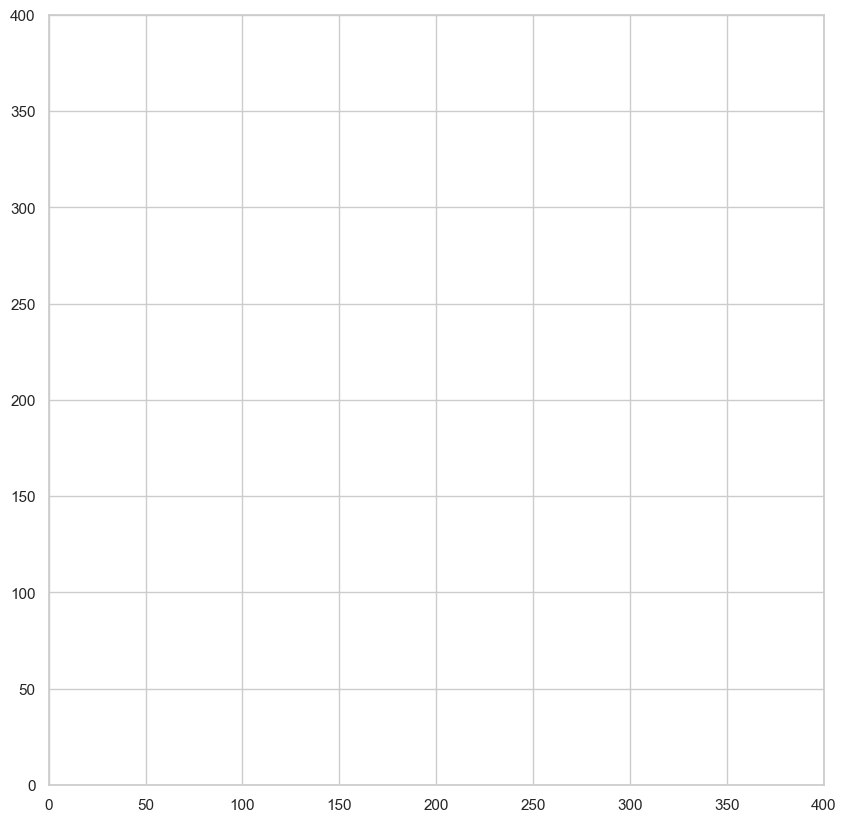

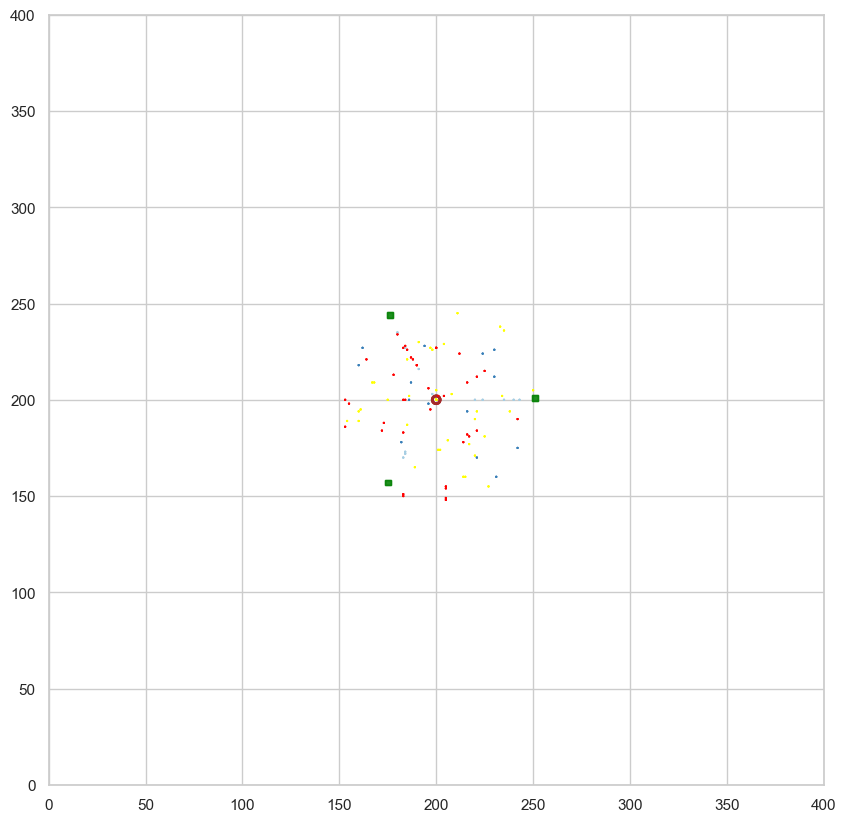

In [93]:
# Parameters for animation
num_bees = 200
width = 400
height = 400
distance = 50
patch_size = 3
bee_speed = 1

# Create model instance
model = HoneybeeModel(num_bees, width, height, distance, patch_size, True, bee_speed)

# Set up the figure, the axis, and the plot elements
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Animation Setup
def run_animation(model, steps=100):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, model.grid.width)
    ax.set_ylim(0, model.grid.height)

    hive_circle = plt.Circle(model.hive_pos, 2, edgecolor='brown', facecolor='none', lw=2)

    # Create patch representations
    patch_rects = []
    for patch in model.patches:
        size = patch.size
        patch_rects.append(plt.Rectangle((patch.pos[0] - 0.5, patch.pos[1] - 0.5), size, size, color='green', alpha=0.5))

    # Create bee representations
    bee_circles = [plt.Circle((0, 0), 0.2, color='yellow') for _ in range(model.num_agents)]

    def init():
        ax.add_patch(hive_circle)
        for patch_rect in patch_rects:
            ax.add_patch(patch_rect)
        for bee_circle in bee_circles:
            ax.add_patch(bee_circle)
        return patch_rects + bee_circles + [hive_circle]

    def update(frame):
        model.step()
        for i, agent in enumerate(model.schedule.agents):
            if isinstance(agent, Bee):
                # Use modulo operator safely by capping the index
                bee_index = i % len(bee_circles)
                bee_circle = bee_circles[bee_index]
                bee_circle.center = agent.pos
                if agent.role == "scout":
                    bee_circle.set_color('#377eb8')  # Blue
                elif agent.role == "recruit":
                    bee_circle.set_color('red')  # Red
                elif agent.role == "employed":
                    bee_circle.set_color('#a6cee3')  # Sky Blue
                elif agent.role == "novice":
                    bee_circle.set_color('yellow')
        return patch_rects + bee_circles + [hive_circle]


    ani = animation.FuncAnimation(fig, update, frames=steps, init_func=init, blit=True, repeat=False)
    return HTML(ani.to_jshtml()) 
    ani.save('honeybee_foraging_animation_waggle.html', writer='html')

# Running the animation with a patch size of 3 (3x3)
run_animation(model, steps=200)


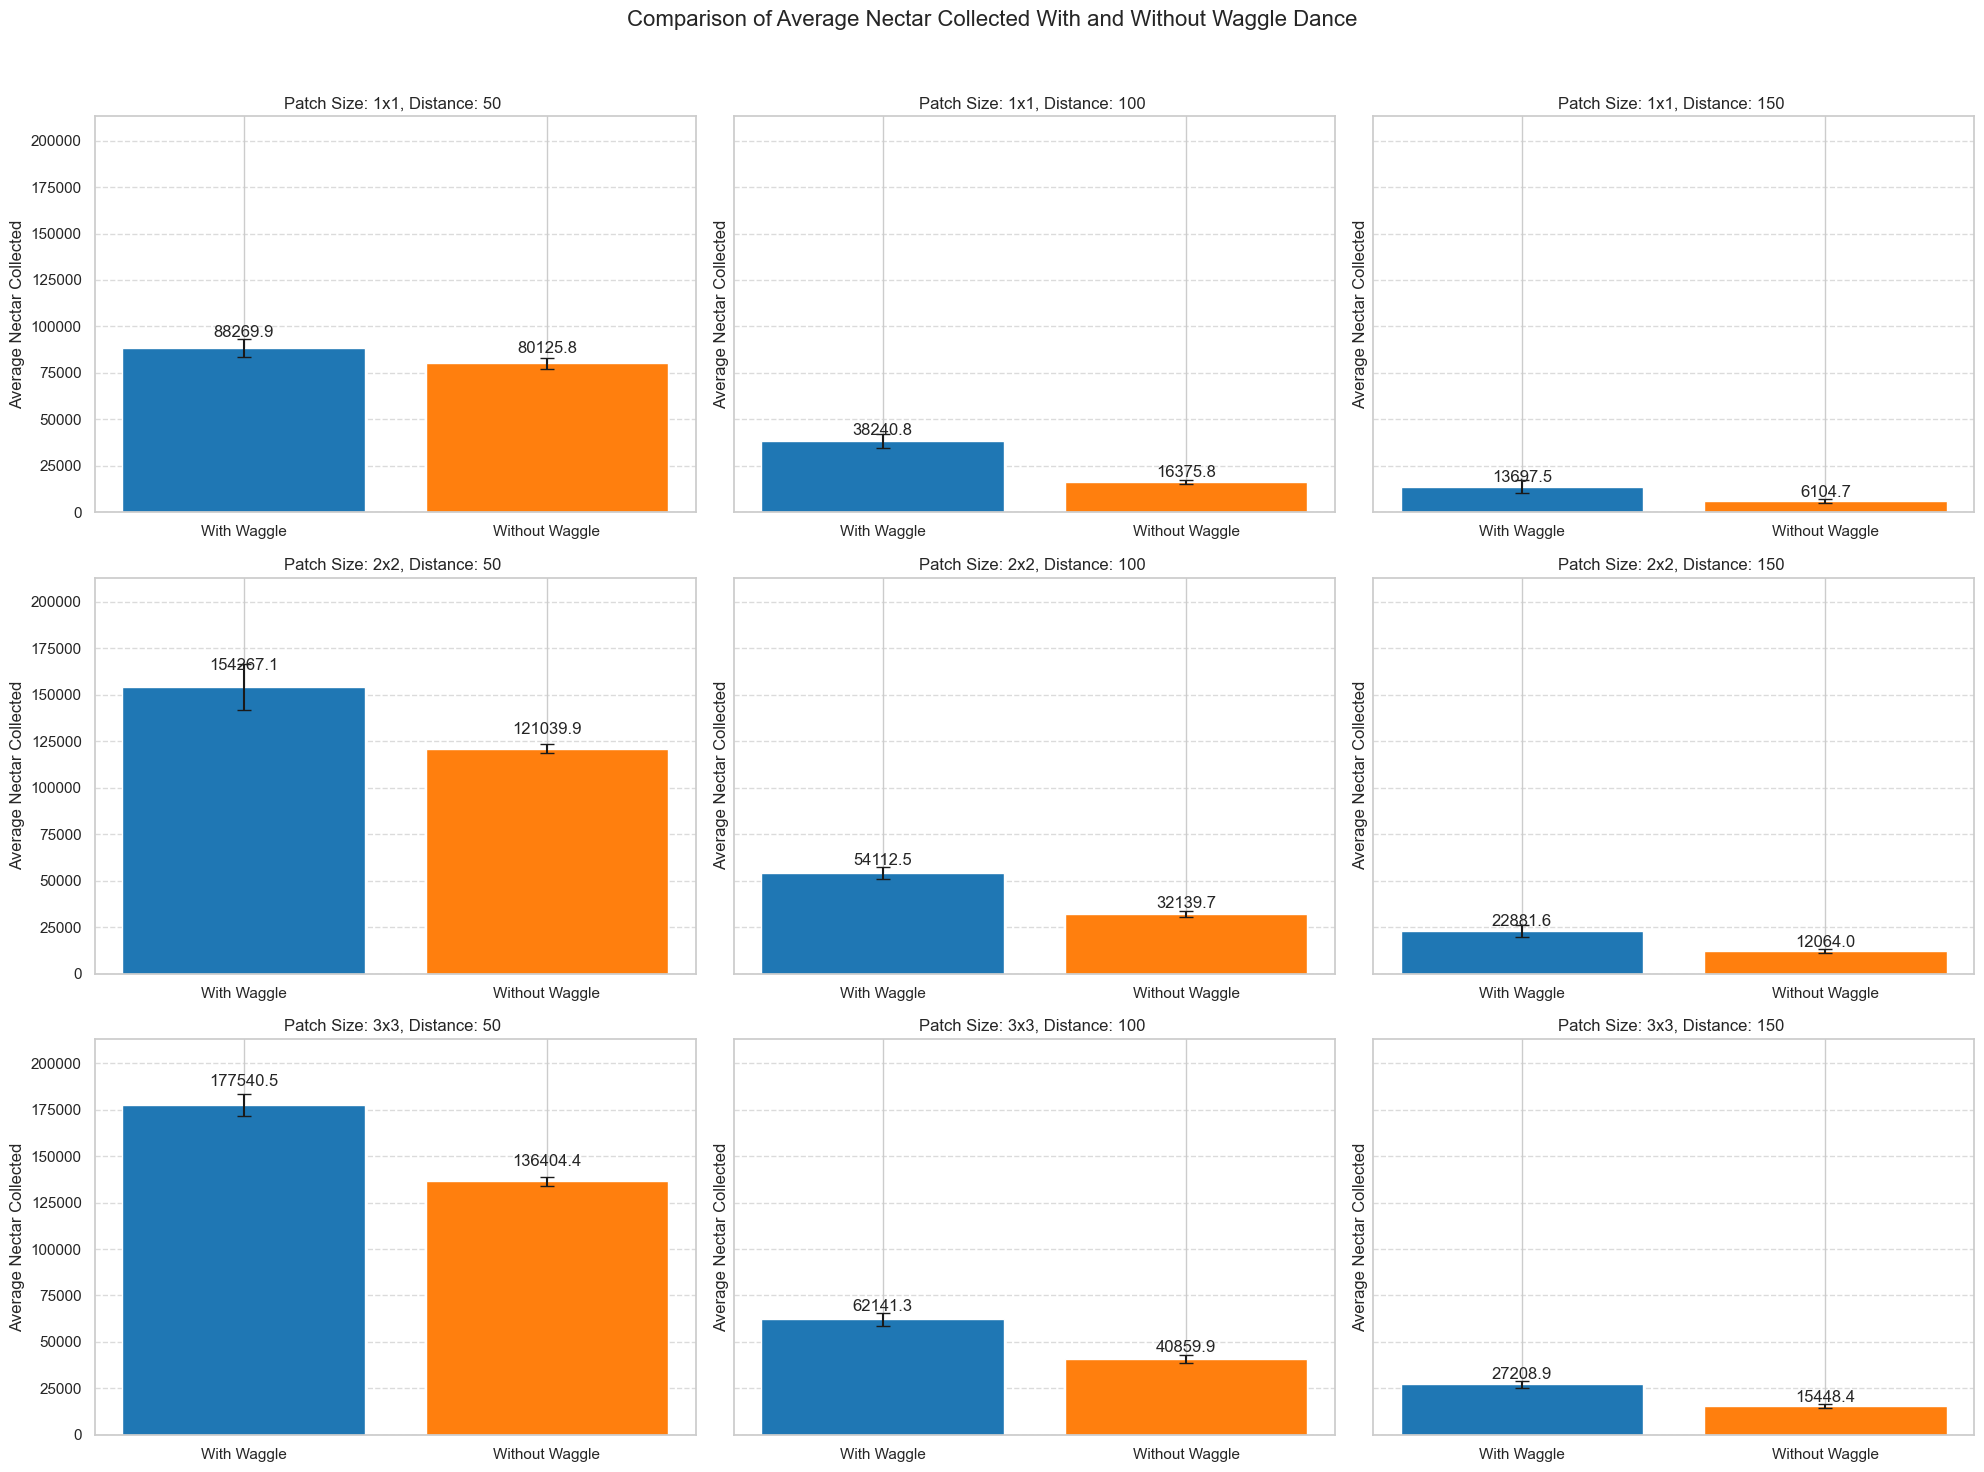

In [94]:
# Function to run experiment and collect average nectar data
def run_experiment(runs, N, width, height, distances, patch_sizes, speed, duration):
    results = []

    for distance in distances:
        for patch_size in patch_sizes:
            nectar_with_waggle = []
            nectar_without_waggle = []

            for _ in range(runs):
                # Model with waggle dance
                model_with_waggle = HoneybeeModel(N, width, height, distance, patch_size, True, speed)
                for _ in range(duration):
                    model_with_waggle.step()
                total_nectar_with_waggle = model_with_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
                nectar_with_waggle.append(total_nectar_with_waggle)

                # Model without waggle dance
                model_without_waggle = HoneybeeModel(N, width, height, distance, patch_size, False, speed)
                for _ in range(duration):
                    model_without_waggle.step()
                total_nectar_without_waggle = model_without_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
                nectar_without_waggle.append(total_nectar_without_waggle)

            # Store results
            results.append({
                "Distance from Hive": distance,
                "Patch Size": f"{patch_size}x{patch_size}",
                "Average Nectar Collected (With Waggle)": np.mean(nectar_with_waggle),
                "Average Nectar Collected (Without Waggle)": np.mean(nectar_without_waggle),
                "Standard Deviation (With Waggle)": np.std(nectar_with_waggle),
                "Standard Deviation (Without Waggle)": np.std(nectar_without_waggle),
            })

    results_df = pd.DataFrame(results)

    # Set the style
    sns.set(style="whitegrid")

    # Plotting the results
    num_rows = len(patch_sizes)
    num_cols = len(distances)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharey=True)
    fig.suptitle("Comparison of Average Nectar Collected With and Without Waggle Dance", fontsize=16)

    if num_rows == 1 and num_cols == 1:
        axs = np.array([[axs]])
    elif num_rows == 1 or num_cols == 1:
        axs = np.array(axs).reshape(num_rows, num_cols)

    for i, patch_size in enumerate(patch_sizes):
        for j, distance in enumerate(distances):
            ax = axs[i, j]
            subset = results_df[(results_df["Distance from Hive"] == distance) & (results_df["Patch Size"] == f"{patch_size}x{patch_size}")]
            bars = ax.bar(["With Waggle", "Without Waggle"], 
                          [subset["Average Nectar Collected (With Waggle)"].values[0], subset["Average Nectar Collected (Without Waggle)"].values[0]],
                          yerr=[subset["Standard Deviation (With Waggle)"].values[0], subset["Standard Deviation (Without Waggle)"].values[0]],
                          capsize=5,
                          color=['#1f77b4', '#ff7f0e'])
            ax.set_title(f"Patch Size: {patch_size}x{patch_size}, Distance: {distance} ", fontsize=12)
            ax.set_ylabel("Average Nectar Collected", fontsize=12)
            ax.set_ylim(0, max(results_df["Average Nectar Collected (With Waggle)"].max(), results_df["Average Nectar Collected (Without Waggle)"].max()) * 1.2)
            ax.grid(True, axis='y', linestyle='--', alpha=0.7)

            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05 * yval, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return results_df

# Parameters for the experiment
runs = 10
N = 200
width = 400
height = 400
distances = [50, 100, 150] #350m, 700m, 1050m
patch_sizes = [1, 2, 3]  # Representing 1x1 (7mx7m), 2x2 (14mx14m), 3x3 (21mx21m)
speed = 1
duration =  3600

# Run the experiment
results_df = run_experiment(runs, N, width, height, distances, patch_sizes, speed, duration)


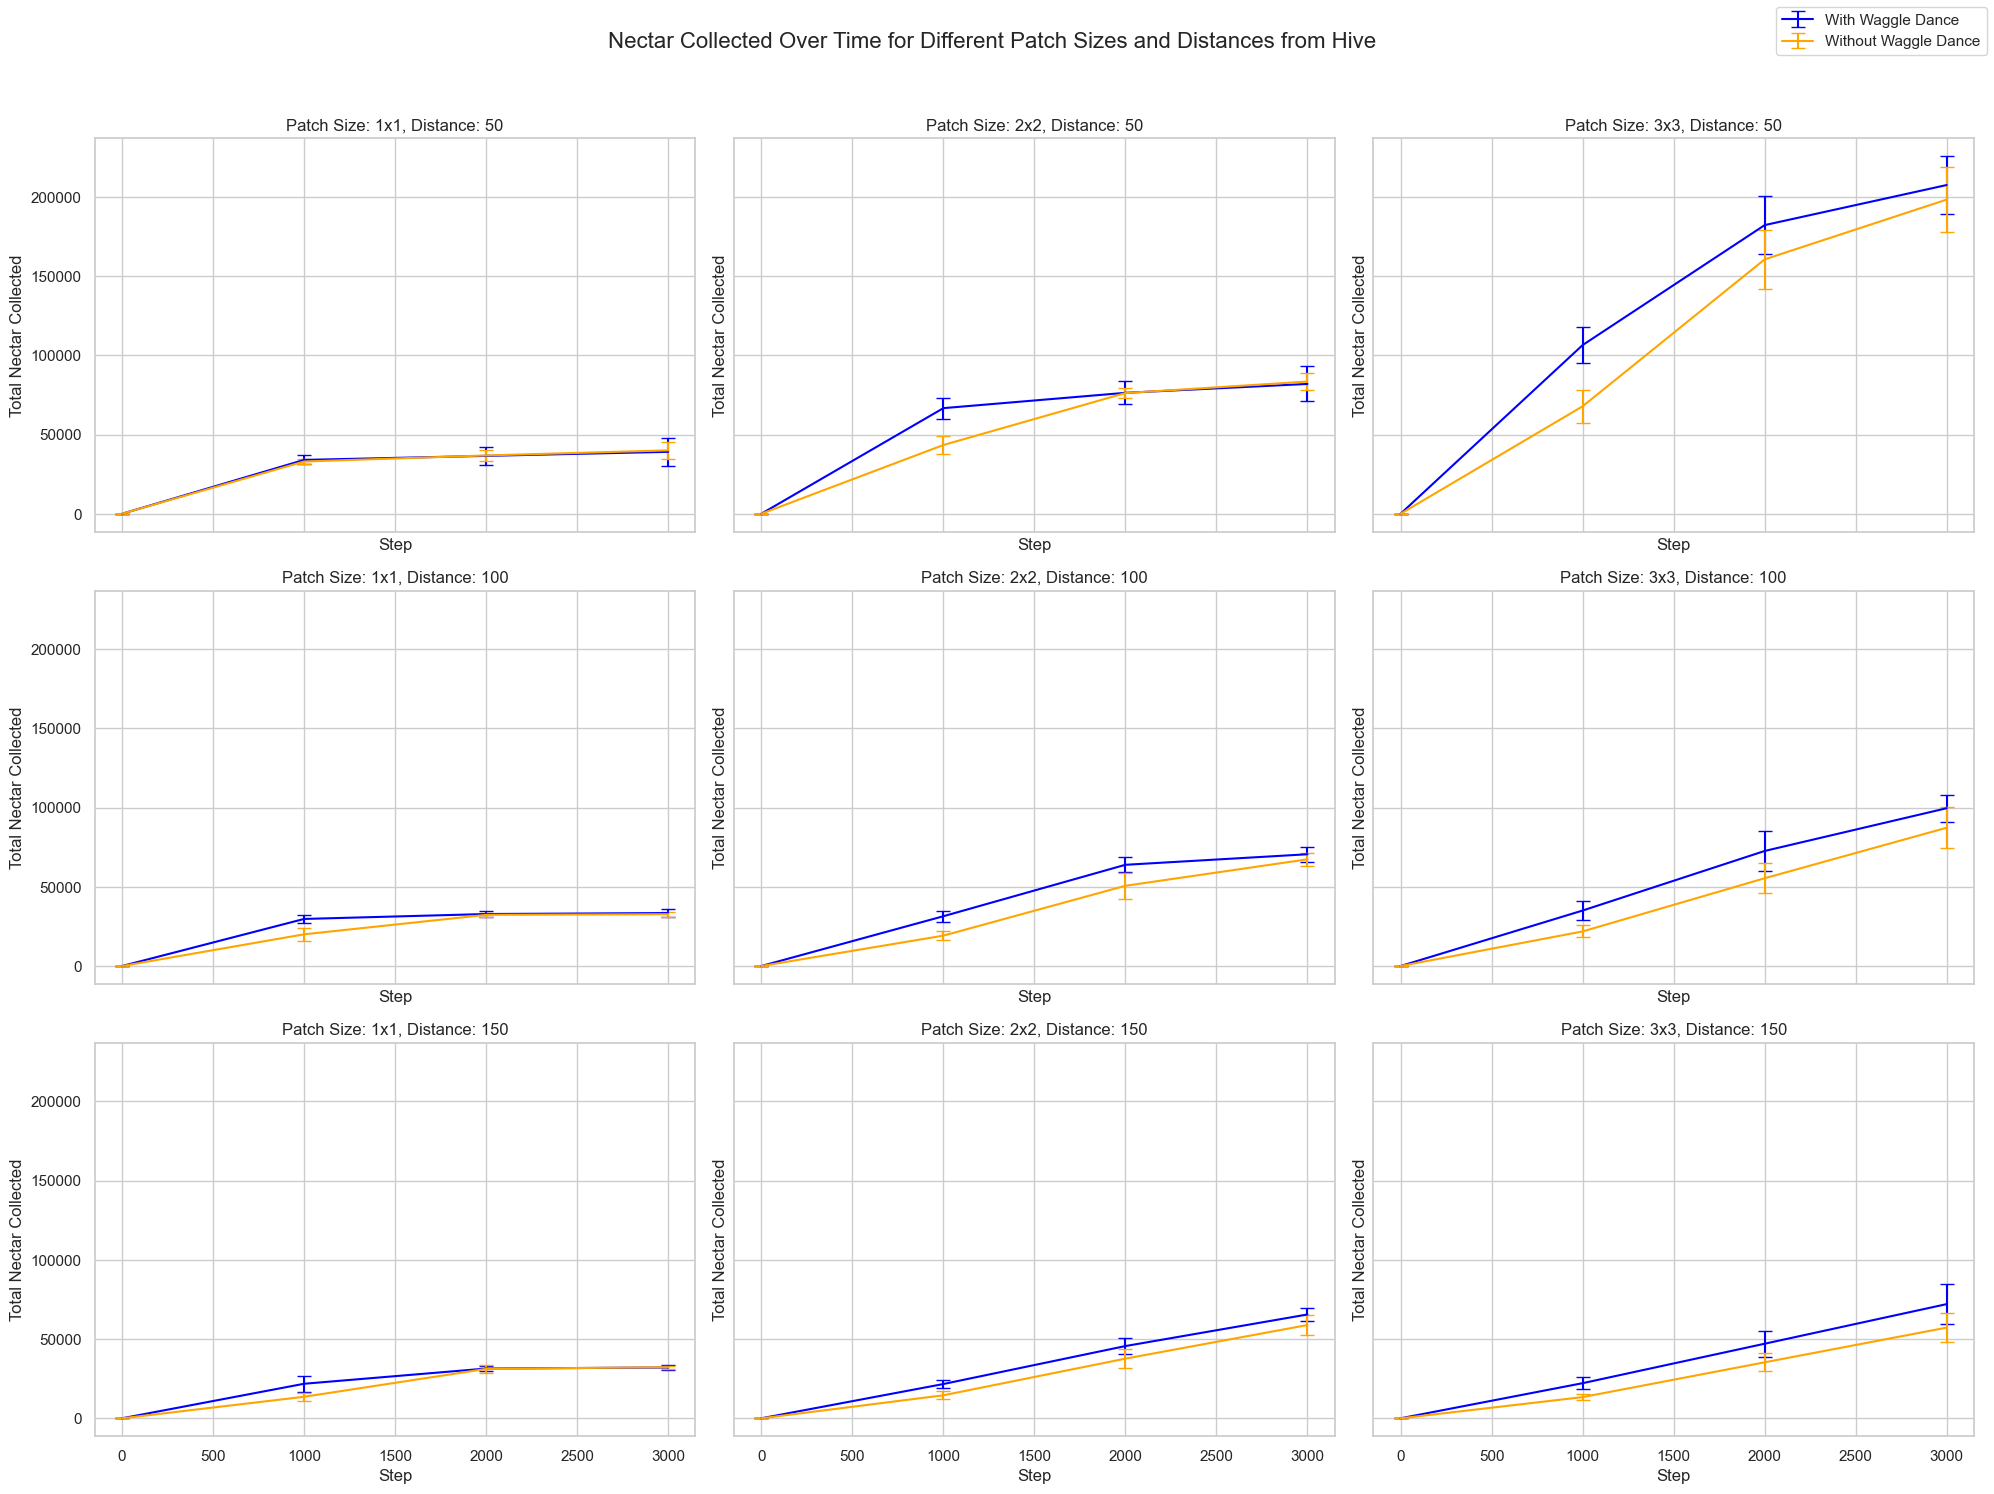

In [105]:
# Function to run the experiment and collect time-series data
def run_experiment_with_time_series(runs, N, width, height, distances, patch_sizes, speed, duration, error_interval=1000):
    time_series_results = []

    for distance in distances:
        for patch_size in patch_sizes:
            steps_data_with_waggle = []
            steps_data_without_waggle = []

            for _ in range(runs):
                # Model with waggle dance
                model_with_waggle = HoneybeeModel(N, width, height, distance, patch_size, True, speed)
                model_without_waggle = HoneybeeModel(N, width, height, distance, patch_size, False, speed)

                run_data_with_waggle = []
                run_data_without_waggle = []

                for step in range(duration):
                    model_with_waggle.step()
                    model_without_waggle.step()

                    total_nectar_with_waggle = model_with_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
                    total_nectar_without_waggle = model_without_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]

                    run_data_with_waggle.append(total_nectar_with_waggle)
                    run_data_without_waggle.append(total_nectar_without_waggle)

                steps_data_with_waggle.append(run_data_with_waggle)
                steps_data_without_waggle.append(run_data_without_waggle)

            # Compute average and standard deviation for each step across runs
            avg_with_waggle = np.mean(steps_data_with_waggle, axis=0)
            std_with_waggle = np.std(steps_data_with_waggle, axis=0)
            avg_without_waggle = np.mean(steps_data_without_waggle, axis=0)
            std_without_waggle = np.std(steps_data_without_waggle, axis=0)

            for step in range(0, duration + 1, error_interval):
                time_series_results.append({
                    "Step": step,
                    "Distance from Hive": distance,
                    "Patch Size": f"{patch_size}x{patch_size}",
                    "Average Nectar Collected With Waggle": avg_with_waggle[step],
                    "Std With Waggle": std_with_waggle[step],
                    "Average Nectar Collected Without Waggle": avg_without_waggle[step],
                    "Std Without Waggle": std_without_waggle[step]
                })

    return pd.DataFrame(time_series_results)

# Function to plot nectar collection over time for all combinations of patch size and distance from hive
def plot_nectar_over_time_with_error_bars(df, distances, patch_sizes):
    num_rows = len(distances)
    num_cols = len(patch_sizes)
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=True, sharey=True)
    fig.suptitle("Nectar Collected Over Time for Different Patch Sizes and Distances from Hive", fontsize=16)

    for i, distance in enumerate(distances):
        for j, patch_size in enumerate(patch_sizes):
            subset = df[(df["Patch Size"] == f"{patch_size}x{patch_size}") & (df["Distance from Hive"] == distance)]
            
            ax = axs[i, j] if num_rows > 1 and num_cols > 1 else (axs[j] if num_rows == 1 else axs[i])
            ax.errorbar(subset["Step"], subset["Average Nectar Collected With Waggle"], 
                        yerr=subset["Std With Waggle"], label="With Waggle Dance", color='blue', capsize=5)
            ax.errorbar(subset["Step"], subset["Average Nectar Collected Without Waggle"], 
                        yerr=subset["Std Without Waggle"], label="Without Waggle Dance", color='orange', capsize=5)
            
            ax.set_title(f"Patch Size: {patch_size}x{patch_size}, Distance: {distance}")
            ax.set_xlabel("Step")
            ax.set_ylabel("Total Nectar Collected")
            ax.grid(True)

    # Add legends only to the first subplot to avoid clutter
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Parameters for the experiment
runs = 10 
N = 200
width = 50
height = 50
speed = 1
duration = 3600
distances = [50, 100, 150]
patch_sizes = [1, 2, 3]

# Run the experiment and get the time series data with error bars
time_series_df = run_experiment_with_time_series(runs, N, width, height, distances, patch_sizes, speed, duration, error_interval=1000)

# Plot the results with error bars
plot_nectar_over_time_with_error_bars(time_series_df, distances, patch_sizes)

# Save the final DataFrame to a CSV file
time_series_df.to_csv("time_series_results.csv", index=False)


        Condition  Statistic   p-value  Normality Assumption
0     With Waggle   0.433854  0.804989  Normally Distributed
1  Without Waggle   0.175244  0.916107  Normally Distributed


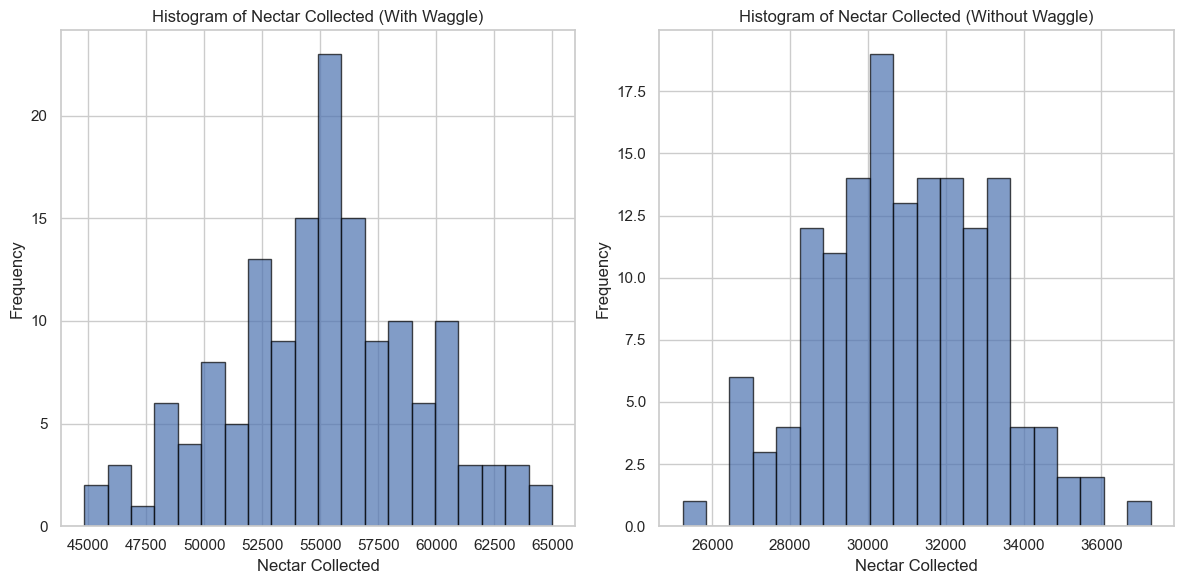

In [96]:
# Function to run the experiment and collect total nectar per run
def run_experiment_per_run(runs, N, width, height, distance, patch_size, speed, duration):
    nectar_with_waggle = []
    nectar_without_waggle = []

    for _ in range(runs):
        # Model with waggle dance
        model_with_waggle = HoneybeeModel(N, width, height, distance, patch_size, True, speed)
        for _ in range(duration):
            model_with_waggle.step()
        total_nectar_with_waggle = model_with_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
        nectar_with_waggle.append(total_nectar_with_waggle)

        # Model without waggle dance
        model_without_waggle = HoneybeeModel(N, width, height, distance, patch_size, False, speed)
        for _ in range(duration):
            model_without_waggle.step()
        total_nectar_without_waggle = model_without_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
        nectar_without_waggle.append(total_nectar_without_waggle)

    return np.array(nectar_with_waggle), np.array(nectar_without_waggle)

# Parameters for the experiment
runs = 150
N = 200
width = 400
height = 400
distance = 100
patch_size = 2 
speed = 1
duration = 3600

# Run the experiment and collect nectar collected per run
nectar_with_waggle, nectar_without_waggle = run_experiment_per_run(runs, N, width, height, distance, patch_size, speed, duration)

# Perform the D'Agostino and Pearson's normality test
stat_with_waggle, p_with_waggle = normaltest(nectar_with_waggle)
stat_without_waggle, p_without_waggle = normaltest(nectar_without_waggle)

# Check the normality assumption
normality_results = {
    "Condition": ["With Waggle", "Without Waggle"],
    "Statistic": [stat_with_waggle, stat_without_waggle],
    "p-value": [p_with_waggle, p_without_waggle],
    "Normality Assumption": [
        "Normally Distributed" if p_with_waggle > 0.05 else "Not Normally Distributed",
        "Normally Distributed" if p_without_waggle > 0.05 else "Not Normally Distributed"
    ]
}

# Convert the results to a DataFrame
normality_df = pd.DataFrame(normality_results)

# Save the normality results to a CSV file
normality_df.to_csv("normality_test_results.csv", index=False)

# Save the nectar collection data to a CSV file
nectar_data_df = pd.DataFrame({
    "Nectar Collected With Waggle": nectar_with_waggle,
    "Nectar Collected Without Waggle": nectar_without_waggle
})
nectar_data_df.to_csv("nectar_collection_data.csv", index=False)

print(normality_df)

# Plotting the histograms for visual inspection
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(nectar_with_waggle, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Nectar Collected (With Waggle)')
plt.xlabel('Nectar Collected')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(nectar_without_waggle, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Nectar Collected (Without Waggle)')
plt.xlabel('Nectar Collected')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


                       sum_sq     df           F        PR(>F)
C(Distance)      4.074831e+11    2.0  973.539293  3.291141e-95
C(Patch_Size)    4.484074e+10    2.0  107.131380  4.718950e-31
C(Waggle_Dance)  1.939920e+10    1.0   92.695318  7.420786e-18
Residual         3.641458e+10  174.0         NaN           NaN


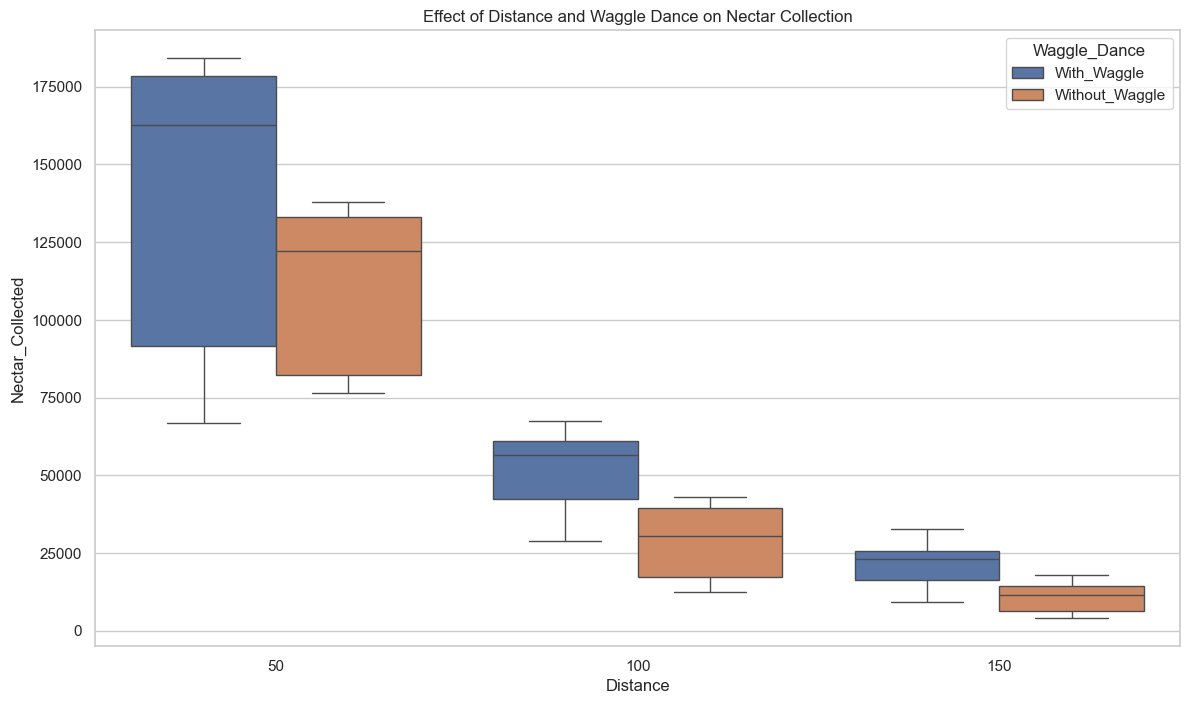

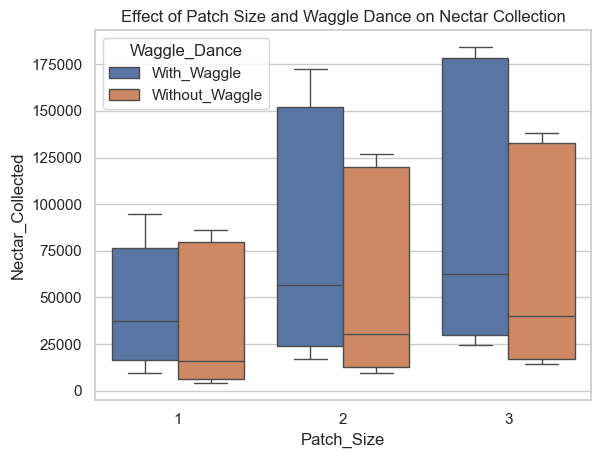

In [97]:
def run_experiment_for_anova(runs, N, width, height, distances, patch_sizes, speed, duration):
    data = []

    for distance in distances:
        for patch_size in patch_sizes:
            for _ in range(runs):
                # Model with waggle dance
                model_with_waggle = HoneybeeModel(N, width, height, distance, patch_size, True, speed)
                for _ in range(duration):
                    model_with_waggle.step()
                total_nectar_with_waggle = model_with_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
                data.append({
                    "Distance": distance,
                    "Patch_Size": patch_size,  # Use underscore instead of space
                    "Waggle_Dance": "With_Waggle",  # Use underscore instead of space
                    "Nectar_Collected": total_nectar_with_waggle
                })

                # Model without waggle dance
                model_without_waggle = HoneybeeModel(N, width, height, distance, patch_size, False, speed)
                for _ in range(duration):
                    model_without_waggle.step()
                total_nectar_without_waggle = model_without_waggle.datacollector.get_model_vars_dataframe()["Total Nectar Collected"].iloc[-1]
                data.append({
                    "Distance": distance,
                    "Patch_Size": patch_size,  # Use underscore instead of space
                    "Waggle_Dance": "Without_Waggle",  # Use underscore instead of space
                    "Nectar_Collected": total_nectar_without_waggle
                })

    Annova_df = pd.DataFrame(data)
    return Annova_df

# Parameters for the experiment
runs = 10
N = 200
width = 400
height = 400
distances = [50, 100, 150]
patch_sizes = [1, 2, 3]  
speed = 1
duration = 3600

# Run the experiment and get the DataFrame
Annova_df = run_experiment_for_anova(runs, N, width, height, distances, patch_sizes, speed, duration)

# Convert Patch_Size to a categorical variable for ANOVA
Annova_df['Patch_Size'] = Annova_df['Patch_Size'].astype('category')

# Fit the ANOVA model
model = ols('Nectar_Collected ~ C(Distance) + C(Patch_Size) + C(Waggle_Dance)', data= Annova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

# Visualize the effect of each factor
plt.figure(figsize=(14, 8))

sns.boxplot(x="Distance", y="Nectar_Collected", hue="Waggle_Dance", data= Annova_df)
plt.title("Effect of Distance and Waggle Dance on Nectar Collection")
plt.show()

sns.boxplot(x="Patch_Size", y="Nectar_Collected", hue="Waggle_Dance", data= Annova_df)
plt.title("Effect of Patch Size and Waggle Dance on Nectar Collection")
plt.show()


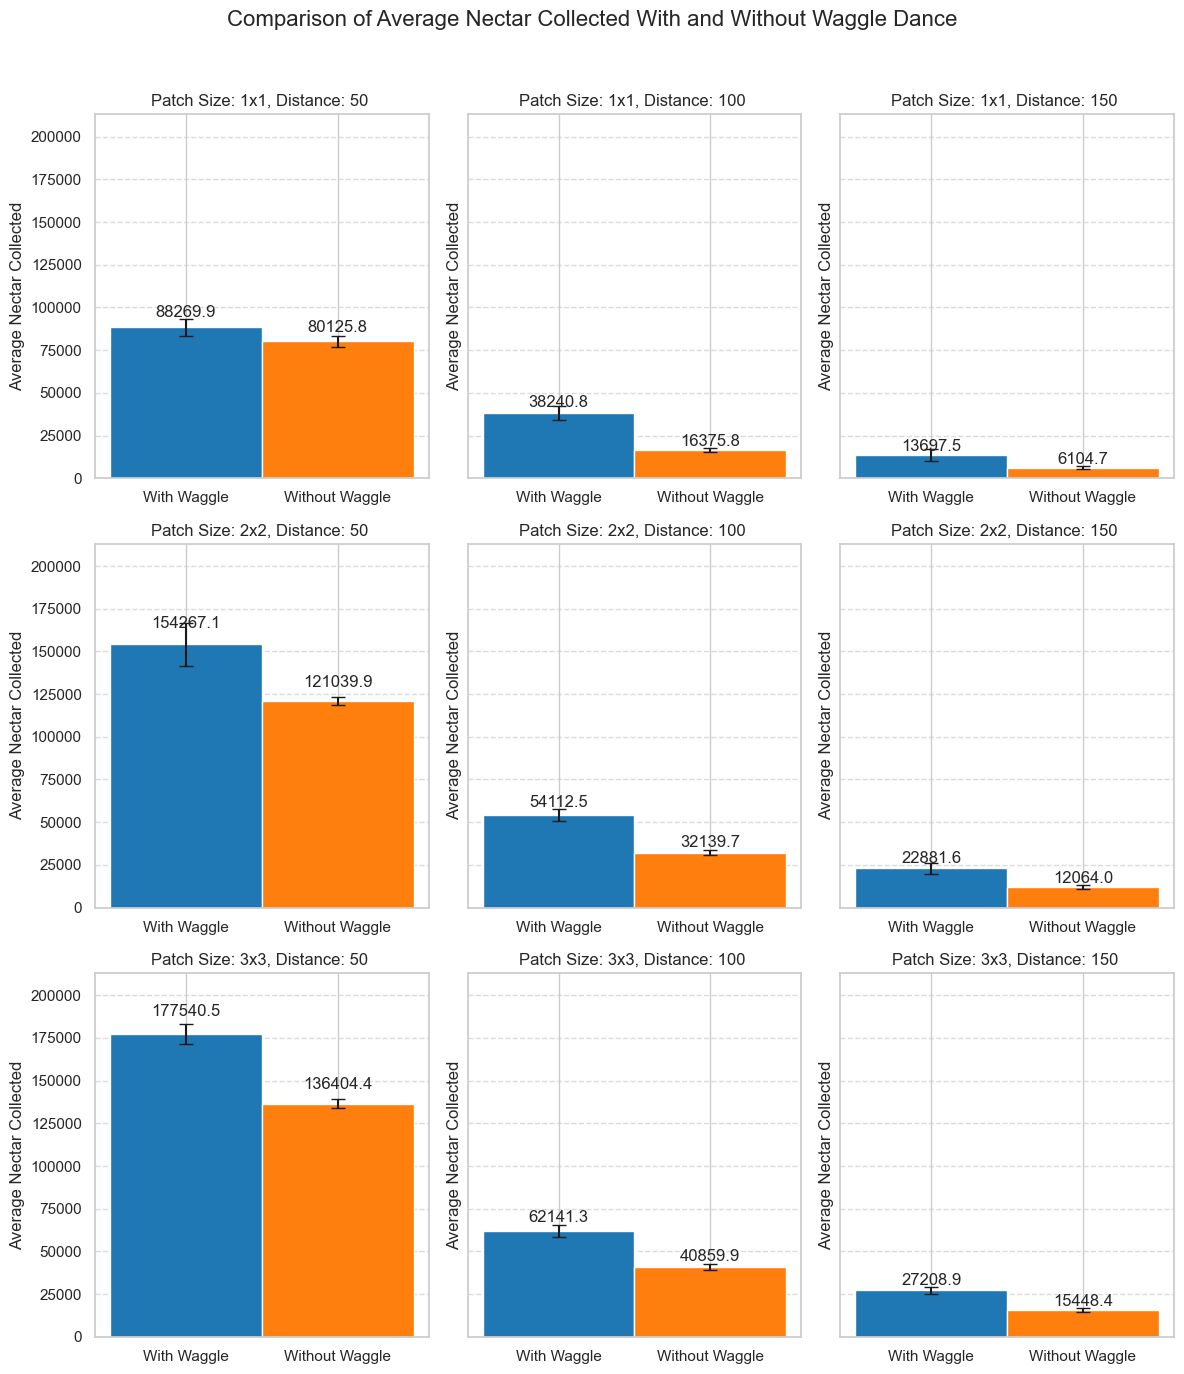

In [110]:
# Set the style
sns.set(style="whitegrid")

# Plotting the results with slimmer bars
num_rows = len(patch_sizes)
num_cols = len(distances)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12,14), sharey=True)
fig.suptitle("Comparison of Average Nectar Collected With and Without Waggle Dance", fontsize=16)

if num_rows == 1 and num_cols == 1:
    axs = np.array([[axs]])
elif num_rows == 1 or num_cols == 1:
    axs = np.array(axs).reshape(num_rows, num_cols)

bar_width = 1  # Adjust the bar width here (smaller value makes slimmer bars)

for i, patch_size in enumerate(patch_sizes):
    for j, distance in enumerate(distances):
        ax = axs[i, j]
        subset = results_df[(results_df["Distance from Hive"] == distance) & (results_df["Patch Size"] == f"{patch_size}x{patch_size}")]
        bars = ax.bar(["With Waggle", "Without Waggle"], 
                      [subset["Average Nectar Collected (With Waggle)"].values[0], subset["Average Nectar Collected (Without Waggle)"].values[0]],
                      yerr=[subset["Standard Deviation (With Waggle)"].values[0], subset["Standard Deviation (Without Waggle)"].values[0]],
                      capsize=5,
                      color=['#1f77b4', '#ff7f0e'],
                      width=bar_width)  # Use the bar_width variable here
        ax.set_title(f"Patch Size: {patch_size}x{patch_size}, Distance: {distance} ", fontsize=12)
        ax.set_ylabel("Average Nectar Collected", fontsize=12)
        ax.set_ylim(0, max(results_df["Average Nectar Collected (With Waggle)"].max(), results_df["Average Nectar Collected (Without Waggle)"].max()) * 1.2)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05 * yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [102]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 3.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [103]:
Average_collection = results_df

Average_collection.to_excel('Average_collection.xlsx')

In [113]:
anova_table.to_excel('Anova_table.xlsx')